# Use Adam till convergence point then use SGDM

In [8]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt
# from PIL import Image

# import wandb

device = torch.device("mps" if getattr(torch,'has_mps',False) else "cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

BATCH_SIZE = 256

cuda:0


## Import dataset

In [15]:
def load_data():
    img_shape = (32, 32)
    transform_train = transforms.Compose([
        # transforms.Resize(img_shape, Image.BILINEAR),
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    transform_test = transforms.Compose([
        # transforms.Resize(img_shape, Image.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_train)
    test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_test)
    print('Number of training data:', len(train_data))
    print('Number of testing data:', len(test_data))

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    return train_data, test_data, train_loader, test_loader
  
train_data, test_data, train_loader, test_loader = load_data()

Files already downloaded and verified
Files already downloaded and verified
Number of training data: 50000
Number of testing data: 10000


## Build model

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(3, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, 1, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(4096, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [17]:
def train(model, train_loader, optimizer, loss_func, epochs=30):
    accuracy_lst = []
    loss_lst = []
    model.train()
    for epoch in tqdm(range(epochs), desc=f"Training progress", colour="#00ff00"):
        total_loss = 0
        correct = 0
        num_labels = 0
        counter = 0
        start_time = time.time()
        for batch_idx, (X, y) in enumerate(tqdm(train_loader, leave=False, desc=f"Epoch {epoch + 1}/{epochs}", colour="#005500")):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = loss_func(output, y)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == y).sum()
            num_labels += len(y)
            counter += 1
        accuracy_lst.append((correct/num_labels).cpu().item())
        loss_lst.append(total_loss/counter)

        end_time = time.time()

        # wandb.log({'Accuracy': accuracy_lst[-1], 'Loss': loss_lst[-1]})

        print('Epoch %d, Loss %4f, Accuracy %4f, finished in %.4f seconds' % (epoch+1, total_loss/counter, correct/num_labels, end_time-start_time))
    
    return accuracy_lst, loss_lst

In [18]:
def evaluate(model, test_loader, loss_func):
    total_loss = 0
    correct = 0
    num_labels = 0
    counter = 0
    model.eval()
    for batch_idx, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)

        output = model(X)

        loss = loss_func(output, y)
        total_loss += loss.item()

        predicted = torch.max(output,1)[1]
        correct += (predicted == y).sum()
        num_labels += len(y)
        counter += 1
    print('Test Loss %4f, Test Accuracy %4f' % (total_loss/counter, correct/num_labels))

## Training

In [19]:
lr = 0.01

model = CNN().to(device)
print(model)

loss_func = nn.CrossEntropyLoss()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=4096, out_features=10, bias=True)
)


### Adam

In [20]:
# Adam
# Adam_run = wandb.init(project="CSI 5340 Project", entity="kwang126", name='Adam')
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=5e-4)

accuracy_lst_Adam, loss_lst_Adam = train(model, train_loader, optimizer, loss_func, 20)
evaluate(model, test_loader, loss_func)
# Adam_run.finish()

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Loss 2.687268, Accuracy 0.379260, finished in 17.5652 seconds


Epoch 2/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Loss 1.292574, Accuracy 0.541860, finished in 11.4088 seconds


Epoch 3/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Loss 1.052150, Accuracy 0.630780, finished in 11.2473 seconds


Epoch 4/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Loss 0.911260, Accuracy 0.683780, finished in 12.8776 seconds


Epoch 5/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Loss 0.842014, Accuracy 0.708520, finished in 11.3167 seconds


Epoch 6/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Loss 0.795767, Accuracy 0.726380, finished in 11.5095 seconds


Epoch 7/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Loss 0.747430, Accuracy 0.743680, finished in 12.4350 seconds


Epoch 8/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Loss 0.732152, Accuracy 0.748000, finished in 12.2287 seconds


Epoch 9/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Loss 0.712801, Accuracy 0.756080, finished in 12.0529 seconds


Epoch 10/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Loss 0.696032, Accuracy 0.759640, finished in 11.9737 seconds


Epoch 11/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Loss 0.681937, Accuracy 0.765780, finished in 11.5354 seconds


Epoch 12/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Loss 0.666093, Accuracy 0.772780, finished in 11.4748 seconds


Epoch 13/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Loss 0.658916, Accuracy 0.773200, finished in 11.5165 seconds


Epoch 14/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Loss 0.659546, Accuracy 0.772480, finished in 11.3564 seconds


Epoch 15/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Loss 0.646418, Accuracy 0.776980, finished in 11.4830 seconds


Epoch 16/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Loss 0.641106, Accuracy 0.778640, finished in 11.6051 seconds


Epoch 17/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Loss 0.636847, Accuracy 0.781520, finished in 12.7960 seconds


Epoch 18/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Loss 0.629020, Accuracy 0.783680, finished in 11.6235 seconds


Epoch 19/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Loss 0.631619, Accuracy 0.782940, finished in 11.3491 seconds


Epoch 20/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Loss 0.621779, Accuracy 0.785880, finished in 11.6076 seconds
Test Loss 0.938314, Test Accuracy 0.686100


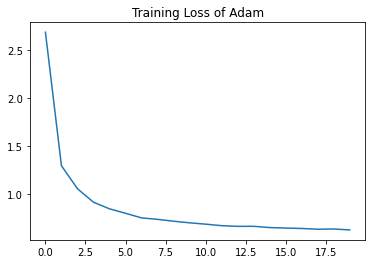

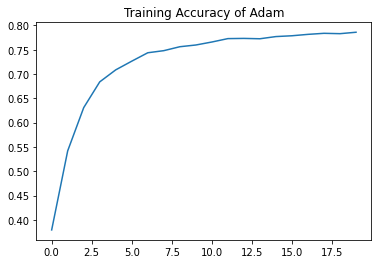

In [21]:
plt.plot(range(20), loss_lst_Adam)
plt.title('Training Loss of Adam')
plt.show()

plt.plot(range(20), accuracy_lst_Adam)
plt.title('Training Accuracy of Adam')
plt.show()

### SGDM

In [22]:
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.95, weight_decay=5e-4)

accuracy_lst_SGD, loss_lst_SGD = train(model, train_loader, optimizer, loss_func, 50)
evaluate(model, test_loader, loss_func)

Training progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Loss 0.443668, Accuracy 0.849120, finished in 15.2828 seconds


Epoch 2/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Loss 0.382788, Accuracy 0.872260, finished in 11.2838 seconds


Epoch 3/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Loss 0.350452, Accuracy 0.883440, finished in 11.3937 seconds


Epoch 4/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Loss 0.327222, Accuracy 0.891820, finished in 11.3583 seconds


Epoch 5/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Loss 0.316756, Accuracy 0.895080, finished in 11.4563 seconds


Epoch 6/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Loss 0.300366, Accuracy 0.901240, finished in 11.7734 seconds


Epoch 7/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Loss 0.283691, Accuracy 0.907520, finished in 11.8265 seconds


Epoch 8/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Loss 0.273531, Accuracy 0.911500, finished in 11.2230 seconds


Epoch 9/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Loss 0.259530, Accuracy 0.917740, finished in 11.3566 seconds


Epoch 10/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Loss 0.252103, Accuracy 0.918300, finished in 11.2980 seconds


Epoch 11/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Loss 0.242492, Accuracy 0.922680, finished in 11.4518 seconds


Epoch 12/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Loss 0.232610, Accuracy 0.926340, finished in 11.2546 seconds


Epoch 13/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Loss 0.224133, Accuracy 0.930000, finished in 11.2454 seconds


Epoch 14/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Loss 0.220974, Accuracy 0.930720, finished in 13.1225 seconds


Epoch 15/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Loss 0.205227, Accuracy 0.937620, finished in 11.4323 seconds


Epoch 16/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Loss 0.198869, Accuracy 0.939480, finished in 11.5170 seconds


Epoch 17/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Loss 0.194166, Accuracy 0.941120, finished in 11.3233 seconds


Epoch 18/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Loss 0.185037, Accuracy 0.945500, finished in 11.2727 seconds


Epoch 19/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Loss 0.181605, Accuracy 0.945620, finished in 11.3694 seconds


Epoch 20/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Loss 0.174018, Accuracy 0.949220, finished in 11.3507 seconds


Epoch 21/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, Loss 0.171465, Accuracy 0.949680, finished in 11.4274 seconds


Epoch 22/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, Loss 0.167008, Accuracy 0.951600, finished in 11.4204 seconds


Epoch 23/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, Loss 0.165604, Accuracy 0.951760, finished in 11.3643 seconds


Epoch 24/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, Loss 0.157813, Accuracy 0.955040, finished in 11.3365 seconds


Epoch 25/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, Loss 0.155078, Accuracy 0.955380, finished in 11.3193 seconds


Epoch 26/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, Loss 0.149325, Accuracy 0.958100, finished in 11.4629 seconds


Epoch 27/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, Loss 0.145204, Accuracy 0.959900, finished in 11.4778 seconds


Epoch 28/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, Loss 0.136754, Accuracy 0.963060, finished in 11.3591 seconds


Epoch 29/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, Loss 0.138469, Accuracy 0.961740, finished in 11.3115 seconds


Epoch 30/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, Loss 0.131784, Accuracy 0.965120, finished in 11.3068 seconds


Epoch 31/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31, Loss 0.128912, Accuracy 0.965700, finished in 11.2930 seconds


Epoch 32/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32, Loss 0.129767, Accuracy 0.965080, finished in 11.4726 seconds


Epoch 33/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33, Loss 0.125296, Accuracy 0.965860, finished in 11.5972 seconds


Epoch 34/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34, Loss 0.128993, Accuracy 0.965120, finished in 12.6492 seconds


Epoch 35/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35, Loss 0.122378, Accuracy 0.966800, finished in 11.8384 seconds


Epoch 36/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36, Loss 0.122306, Accuracy 0.967080, finished in 11.5534 seconds


Epoch 37/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37, Loss 0.126223, Accuracy 0.963820, finished in 11.5586 seconds


Epoch 38/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38, Loss 0.123061, Accuracy 0.966640, finished in 11.4296 seconds


Epoch 39/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39, Loss 0.110258, Accuracy 0.971560, finished in 11.2980 seconds


Epoch 40/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40, Loss 0.112290, Accuracy 0.971740, finished in 11.3983 seconds


Epoch 41/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41, Loss 0.105638, Accuracy 0.974200, finished in 11.4358 seconds


Epoch 42/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42, Loss 0.115063, Accuracy 0.968500, finished in 11.5464 seconds


Epoch 43/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43, Loss 0.118362, Accuracy 0.967340, finished in 11.5026 seconds


Epoch 44/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44, Loss 0.112753, Accuracy 0.969720, finished in 11.4395 seconds


Epoch 45/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45, Loss 0.104123, Accuracy 0.974040, finished in 11.4083 seconds


Epoch 46/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46, Loss 0.101987, Accuracy 0.975480, finished in 11.5335 seconds


Epoch 47/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47, Loss 0.103089, Accuracy 0.973720, finished in 11.4420 seconds


Epoch 48/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48, Loss 0.100335, Accuracy 0.975140, finished in 11.4744 seconds


Epoch 49/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49, Loss 0.104179, Accuracy 0.973340, finished in 11.4524 seconds


Epoch 50/50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50, Loss 0.098120, Accuracy 0.975540, finished in 11.3258 seconds
Test Loss 1.089982, Test Accuracy 0.744300


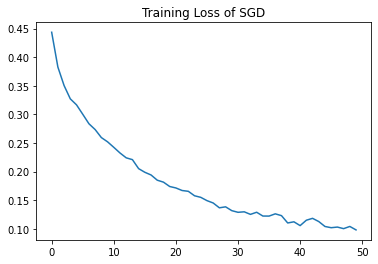

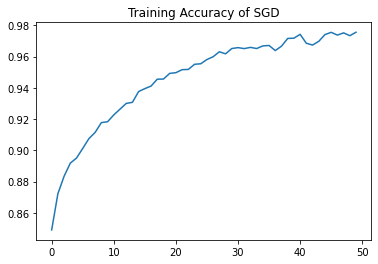

In [23]:
plt.plot(range(50), loss_lst_SGD)
plt.title('Training Loss of SGD')
plt.show()

plt.plot(range(50), accuracy_lst_SGD)
plt.title('Training Accuracy of SGD')
plt.show()